In [31]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import re
import sys
sys.path.append('../../util/')
import sgt
from collections import Counter
from nltk.stem.snowball import EnglishStemmer
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
st = EnglishStemmer()

In [3]:
# create a corpus to give to sklearn
def create_corpus_for_voc(df):
    doc = []
    for i in df.Text.tolist():
        #Remove some non-ascii characters and 'aa's
        i = re.sub(r'aA|aa', 'a', i)
        i = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', i)
        i = i.lower()
        doc.append(i)  
    return doc

In [4]:
# Get a vocabulary using sklearn's filtering
def get_voc(corpus, ngram, mindf):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(ngram,ngram),min_df=mindf)
    f = vectorizer.fit_transform(corpus)
    return set(sorted(vectorizer.get_feature_names()))

In [5]:
# compute unigram-frequency dict using the same preprocessing, using only words from the vocabulary
def create_unigram_freq_dict(df, voc):
    text = []
    for line in df.Text.tolist():
        line = re.sub(r'aA|aa', 'a', line)
        line = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', line).lower()
        line = re.findall(u'(?u)\\b\\w\\w+\\b', line)
        line = [st.stem(word) for word in line if word in voc]
        text.append(dict(Counter(line)))
    return text

In [6]:
def create_timelist(df):
    timelist = df.PublishDate.drop_duplicates().tolist()
    timelist = [str(i)[:7] for i in timelist]
    return sorted(list(set(timelist)))

In [7]:
def create_df_time(df, time):
    return df[df.PublishDate.str[:7] == time]

In [8]:
# calculate unigram probabilities by simple Good Turing smoothing.
# imput: unigram-freq dict
# output: unigram-prob dict, mimic of a document-term matrix
# if unigram is in this doc, prob = the unigram prob calculated by sgt
# otherwise, prob = the probability given to "all unknown unigrams" by sgt
def calc_sgt(line_dict, voc):
    prob_line = []
    sgt_line = sgt.simpleGoodTuringProbs(line_dict)
    num_abs_words = len(voc - set(line_dict.keys()))
    for word in voc:
        if word in line_dict.keys():
            prob_line.append(sgt_line[0][word])
        else:
            prob_line.append(sgt_line[1]/float(num_abs_words))
    return prob_line

In [9]:
def calc_kl(p, q):
    return sum([p[i]*(np.log2(p[i]/q[i])) for i in range(len(p))])

In [19]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[2]
        head = sorted(aves)[97]
        return (ave_original, tail, head)

In [29]:
def calc_window_kl(df, min_df):
    # len(df_t) must > min_df
    # tune this for filtering?

    # output of the following pipeline:
    # a list of lists, each list containing sgt word probablity
    # word order is supposed to be the same
    corp = create_corpus_for_voc(df)
    sgt_list = []
    vocab = get_voc(corp,1,min_df)
    unigram_dict = create_unigram_freq_dict(df, vocab)
    for i in unigram_dict:
        sgt_list.append(calc_sgt(i, vocab))

    # calculate kl.
    # std: "standard work", average of the numpy matrix
    # calculate kl of each work - std work in each month
    # then use the average as kl of the month
    sgt_array = np.asarray(sgt_list)
#     std = np.mean(sgt_array, axis=0)
    kl_window = []
    for i in range(len(sgt_array)):
        for j in range(i+1, len(sgt_array)):
            kl = calc_kl(sgt_array[i],sgt_array[j])
            kl_window.append(kl)
    return [i for i in kl_window if not np.isnan(i) and not np.isinf(i)]

In [10]:
df = pd.read_csv('../../data/shakespare_william_works_preprocessed.tsv', sep = '\t')

In [11]:
df['Author'].value_counts().head(1).index.tolist()[0]

'Lady_Loki'

In [32]:
min_df = 2

for author in df.Author.drop_duplicates().tolist():
    df_Au = df[df.Author == author]
    if len(df_Au) > 1:
        df_nonAu = df[df.Author != author]
        kl_Au = calc_window_kl(df_Au, min_df)
        if len(kl_Au) > 1:
            kl_Au = bootstrap_resample(kl_Au)
        kl_nonAu = bootstrap_resample(calc_monthly_kl(df_nonAu, min_df))
        if len(kl_nonAu) > 1:
            kl_nonAu = bootstrap_resample(kl_nonAu)
    break

p0 = 0.302491
Regression: log(z) = -2.073099*log(r) + 4.406180
p0 = 0.570707
Regression: log(z) = -2.790522*log(r) + 4.880108
p0 = 0.330623
Regression: log(z) = -1.969512*log(r) + 4.718936
p0 = 0.454545
Regression: log(z) = -2.809953*log(r) + 5.542336
p0 = 0.375000
Regression: log(z) = -2.265026*log(r) + 3.168403
p0 = 0.759124
Regression: log(z) = -3.249291*log(r) + 4.515464
p0 = 0.732323
Regression: log(z) = -2.835726*log(r) + 4.815456
p0 = 0.527950
Regression: log(z) = -2.890855*log(r) + 5.422920
p0 = 0.549107
Regression: log(z) = -2.590401*log(r) + 4.685370
p0 = 0.640777
Regression: log(z) = -2.702380*log(r) + 4.118602
p0 = 0.467577
Regression: log(z) = -2.751783*log(r) + 5.168903
p0 = 0.595960
Regression: log(z) = -2.923238*log(r) + 4.960409
p0 = 0.675000
Regression: log(z) = -3.152410*log(r) + 4.705415
p0 = 0.428962
Regression: log(z) = -2.453289*log(r) + 4.983646
p0 = 0.573964
Regression: log(z) = -1.946858*log(r) + 3.507736
p0 = 0.564748
Regression: log(z) = -2.849456*log(r) + 5

/Users/jingy/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/jingy/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app



Regression: log(z) = -2.709594*log(r) + 5.264066
3556
p0 = 0.353271
Regression: log(z) = -2.651880*log(r) + 5.742840
p0 = 0.648045
Regression: log(z) = -2.644106*log(r) + 4.360943
p0 = 0.517799
Regression: log(z) = -2.579055*log(r) + 4.892263
p0 = 0.674208
Regression: log(z) = -2.949882*log(r) + 4.880990
p0 = 0.496933
Regression: log(z) = -2.565639*log(r) + 5.053646
p0 = 0.403922
Regression: log(z) = -2.819329*log(r) + 5.774854
p0 = 0.283812
Regression: log(z) = -2.464135*log(r) + 6.402562
p0 = 0.556314
Regression: log(z) = -2.651342*log(r) + 5.104189
p0 = 0.465753
Regression: log(z) = -2.466614*log(r) + 5.451993
p0 = 0.430796
Regression: log(z) = -2.550163*log(r) + 5.566548
p0 = 0.583026
Regression: log(z) = -3.000085*log(r) + 5.112439
p0 = 0.635870
Regression: log(z) = -2.761706*log(r) + 4.570850
p0 = 0.410866
Regression: log(z) = -2.635418*log(r) + 5.695176
p0 = 0.595238
Regression: log(z) = -2.812203*log(r) + 3.401192
p0 = 0.415565
Regression: log(z) = -2.747892*log(r) + 6.064912


/Users/jingy/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


KeyboardInterrupt: 

([<matplotlib.axis.XTick at 0x1142a06d0>,
 <a list of 58 Text xticklabel objects>)

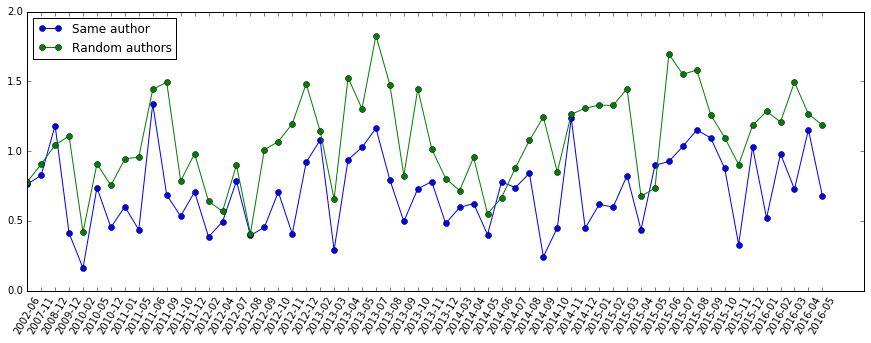

In [119]:
plt.figure(figsize = (15,5))
plt.plot([kl_Au[k] for k in sorted(kl_Au.keys())], 'o-')
plt.plot([kl_Rand[k] for k in sorted(kl_Rand.keys())], 'o-')
plt.legend(['Same author','Random authors'], loc='upper left')
plt.xticks(np.arange(len(kl_Au)), sorted(kl_Au.keys()), rotation=60)
